# Training an CNN to automatically classify storm morphology

### Preprocessing

1) Set the number of classes and size of the image (including the '3rd' dimension, even though these are greyscale)

2) Read in the files using the get_example_data utility

3) Normalize the data by 80 dBZ

4) Verify the shape of the training, validation, and testing datasets

5) Transform the "single number" classifications into keras friendly arrays.

In [1]:
#Based on examples from the Keras documentation
import sys
sys.path.insert(0, '..')
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pickle
from utils.get_images import get_example_data

num_classes = 6
input_shape = (136, 136, 1)

(x_train, y_train) = get_example_data('training', data_dir="../data/pkls/")
(x_val, y_val) = get_example_data('validation', data_dir="../data/pkls/")
(x_test, y_test) = get_example_data('testing', data_dir="../data/pkls/")

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1331, 136, 136, 1)
1331 train samples
110 validate samples
300 test samples


### Create a simple 3 convolutional and 1 dense layer CNN

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


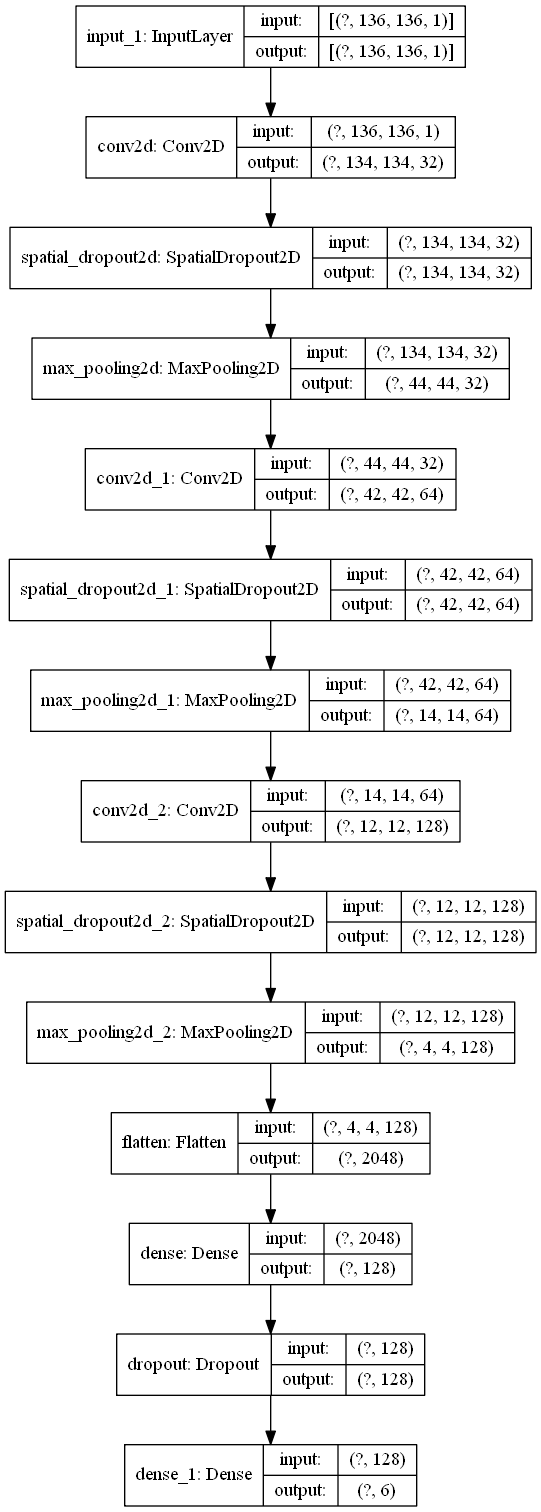

In [2]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

keras.utils.plot_model(model, show_shapes=True)

### Use Data Augmentation to reduce overfitting

We can show how this works with one example.  

<AxesSubplot:xlabel='km', ylabel='km'>

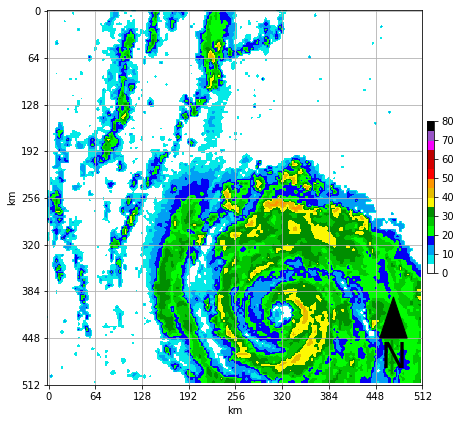

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

from utils.map_helper import radar_colormap, draw_box_plot
from matplotlib.colors import BoundaryNorm

cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

sample = x_test[52]
ax = plt.subplot(1,1,1)
draw_box_plot(ax, sample.squeeze()*80)

We should try to avoid shifting the image left and right, because the location of the 
storm report is right in the middle of each image.  Instead, rotate the image and zoom in and out slightly.
It is also important to ask yourself, does the image augmentation make sense?

We can visualize this with 9 randomly generated examples.

Using TensorFlow backend.


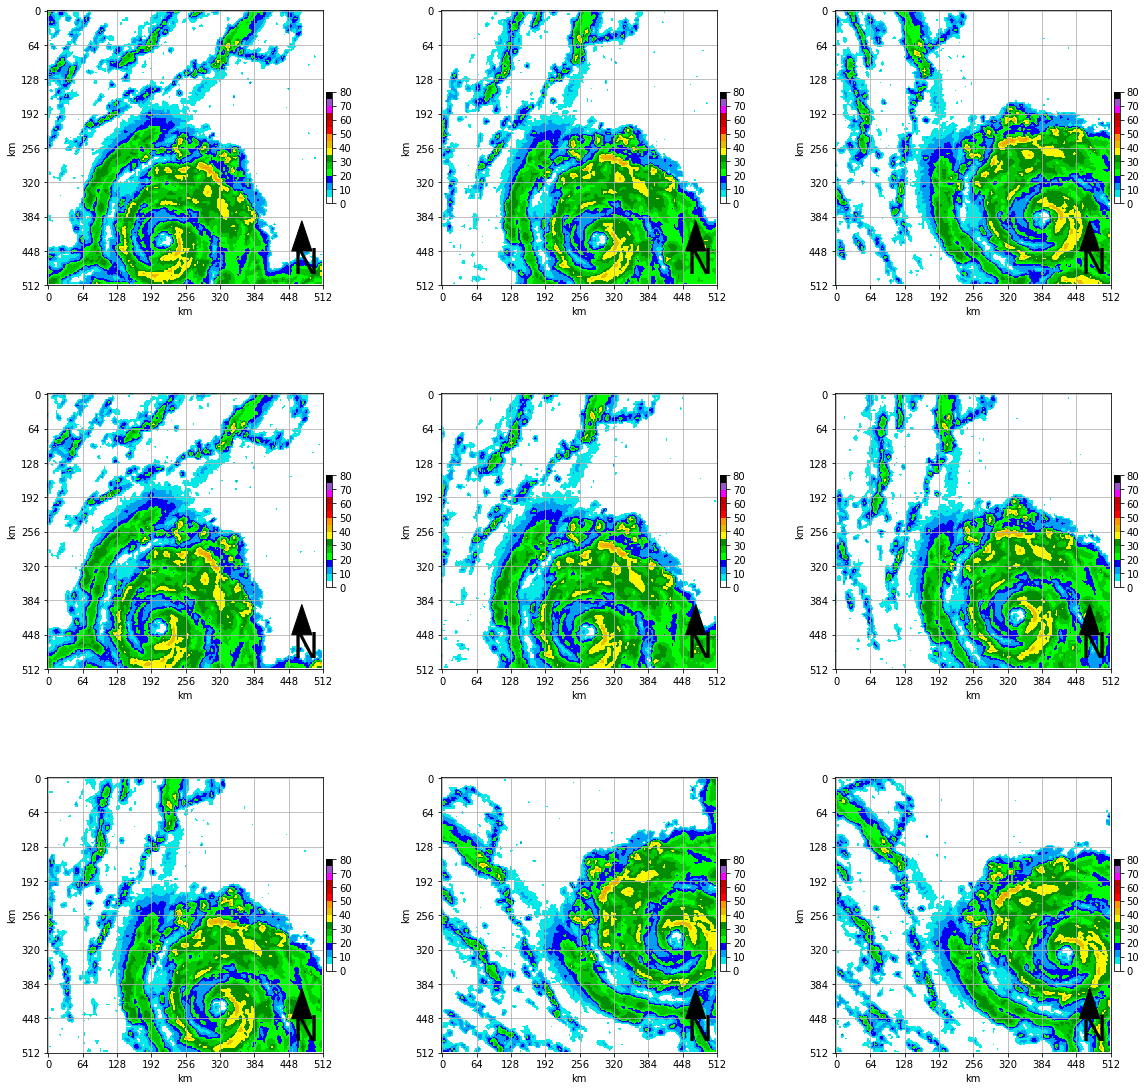

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

plt.rcParams['figure.figsize'] = 20, 20

samples = expand_dims(sample, 0)

datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

aug_imgs = datagen.flow(samples, batch_size=1)

for i in range(9):
   
    ax = plt.subplot(3,3,i+1)

    batch = aug_imgs.next()

    draw_box_plot(ax, batch[0].squeeze()*80)

Create an image generator for the training data and validation data and pass these values into model.fit().  Wait for the model to finish 100 epochs and test how it did!

Note: modify the "workers" argument depending on what kind of CPU you have.  This was tested on a 20 core machine.

In [5]:
batch_size = 128
epochs = 100

traingen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")
valgen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

datagen.fit(x_train)
valgen.fit(x_val)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=epochs, steps_per_epoch=len(x_train) / 32, 
                    validation_data=valgen.flow(x_val, y_val, batch_size=32), workers=8)

Epoch 1/100
42/41 [==============================] - 4s 96ms/step - loss: 1.3009 - acc: 0.4688 - val_loss: 0.9079 - val_acc: 0.6455
Epoch 2/100
42/41 [==============================] - 1s 23ms/step - loss: 1.0258 - acc: 0.6281 - val_loss: 0.7887 - val_acc: 0.7273
Epoch 3/100
42/41 [==============================] - 1s 22ms/step - loss: 0.9498 - acc: 0.6657 - val_loss: 0.8460 - val_acc: 0.7273
Epoch 4/100
42/41 [==============================] - 1s 24ms/step - loss: 0.8787 - acc: 0.6912 - val_loss: 0.8267 - val_acc: 0.7000
Epoch 5/100
42/41 [==============================] - 1s 25ms/step - loss: 0.8123 - acc: 0.7220 - val_loss: 0.7022 - val_acc: 0.7818
Epoch 6/100
42/41 [==============================] - 1s 24ms/step - loss: 0.7707 - acc: 0.7536 - val_loss: 0.6696 - val_acc: 0.7909
Epoch 7/100
42/41 [==============================] - 1s 25ms/step - loss: 0.7450 - acc: 0.7551 - val_loss: 0.7060 - val_acc: 0.7909
Epoch 8/100
42/41 [==============================] - 1s 25ms/step - loss: 0.

42/41 [==============================] - 1s 22ms/step - loss: 0.4171 - acc: 0.8715 - val_loss: 0.4024 - val_acc: 0.8636
Epoch 38/100
42/41 [==============================] - 1s 22ms/step - loss: 0.4170 - acc: 0.8775 - val_loss: 0.3359 - val_acc: 0.8909
Epoch 39/100
42/41 [==============================] - 1s 24ms/step - loss: 0.4008 - acc: 0.8850 - val_loss: 0.3838 - val_acc: 0.8636
Epoch 40/100
42/41 [==============================] - 1s 25ms/step - loss: 0.4096 - acc: 0.8843 - val_loss: 0.3022 - val_acc: 0.9091
Epoch 41/100
42/41 [==============================] - 1s 25ms/step - loss: 0.4006 - acc: 0.8715 - val_loss: 0.3313 - val_acc: 0.8909
Epoch 42/100
42/41 [==============================] - 1s 25ms/step - loss: 0.3882 - acc: 0.8813 - val_loss: 0.3188 - val_acc: 0.8818
Epoch 43/100
42/41 [==============================] - 1s 22ms/step - loss: 0.4169 - acc: 0.8730 - val_loss: 0.3706 - val_acc: 0.8636
Epoch 44/100
42/41 [==============================] - 1s 22ms/step - loss: 0.3719 

42/41 [==============================] - 1s 22ms/step - loss: 0.3127 - acc: 0.9091 - val_loss: 0.3657 - val_acc: 0.8727
Epoch 75/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2892 - acc: 0.9091 - val_loss: 0.2594 - val_acc: 0.8909
Epoch 76/100
42/41 [==============================] - 1s 22ms/step - loss: 0.3071 - acc: 0.9031 - val_loss: 0.3124 - val_acc: 0.8909
Epoch 77/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2984 - acc: 0.9121 - val_loss: 0.4018 - val_acc: 0.8727
Epoch 78/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2937 - acc: 0.9091 - val_loss: 0.3447 - val_acc: 0.8818
Epoch 79/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2676 - acc: 0.9144 - val_loss: 0.2762 - val_acc: 0.9091
Epoch 80/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2867 - acc: 0.9031 - val_loss: 0.2939 - val_acc: 0.8909
Epoch 81/100
42/41 [==============================] - 1s 22ms/step - loss: 0.2949 

# Check the change in training and validation accuracy over epochs.

Divergence of these two generally suggests overfitting.  This can be addressed by image augmentation, 
dropout, and getting more data.

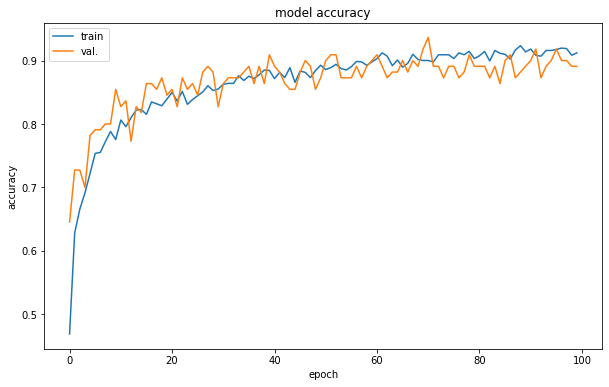

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

### Check the testing accuracy

If it is similar to the validation accuracy, the model is probably learning something.

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6389258912205696
Test accuracy: 0.87666667


### Apply the model to the testing images and compare the predictions to the actual labels

In [8]:
from utils.get_tables import get_svrgis_table, get_pred_tables

actual = get_pred_tables(data_dir="../data/csvs/", example=True, remove_first_row=True)

svrgis = get_svrgis_table(data_dir="../data/csvs/")

actual = actual.join(svrgis)

actual.head()

,Class Code,Class Name,om,tz,st,stf,stn,mag,inj,fat,...,f3,f4,fc,init_date,fmt_date,date_utc,yr,mo,dy,hr
UNID,,,,,,,,,,,,,,,,,,,,,
199604200208z000000206,0,Cellular,206,3,IL,17,38,0,0,0,...,0,0,0,1996-04-19-20:08:00,4/19/1996 20:08,4/20/1996 2:08,1996,4,20,2
199604192244z000000197,0,Cellular,197,3,IL,17,8,0,0,0,...,0,0,0,1996-04-19-16:44:00,4/19/1996 16:44,4/19/1996 22:44,1996,4,19,22
199605280130z000000300,0,Cellular,300,3,IL,17,49,0,0,0,...,0,0,0,1996-05-27-19:30:00,5/27/1996 19:30,5/28/1996 1:30,1996,5,28,1
199605280140z000000298,0,Cellular,298,3,IL,17,50,0,0,0,...,0,0,0,1996-05-27-19:40:00,5/27/1996 19:40,5/28/1996 1:40,1996,5,28,1
199604192307z000000207,0,Cellular,207,3,IL,17,11,2,1,0,...,0,0,0,1996-04-19-17:07:00,4/19/1996 17:07,4/19/1996 23:07,1996,4,19,23


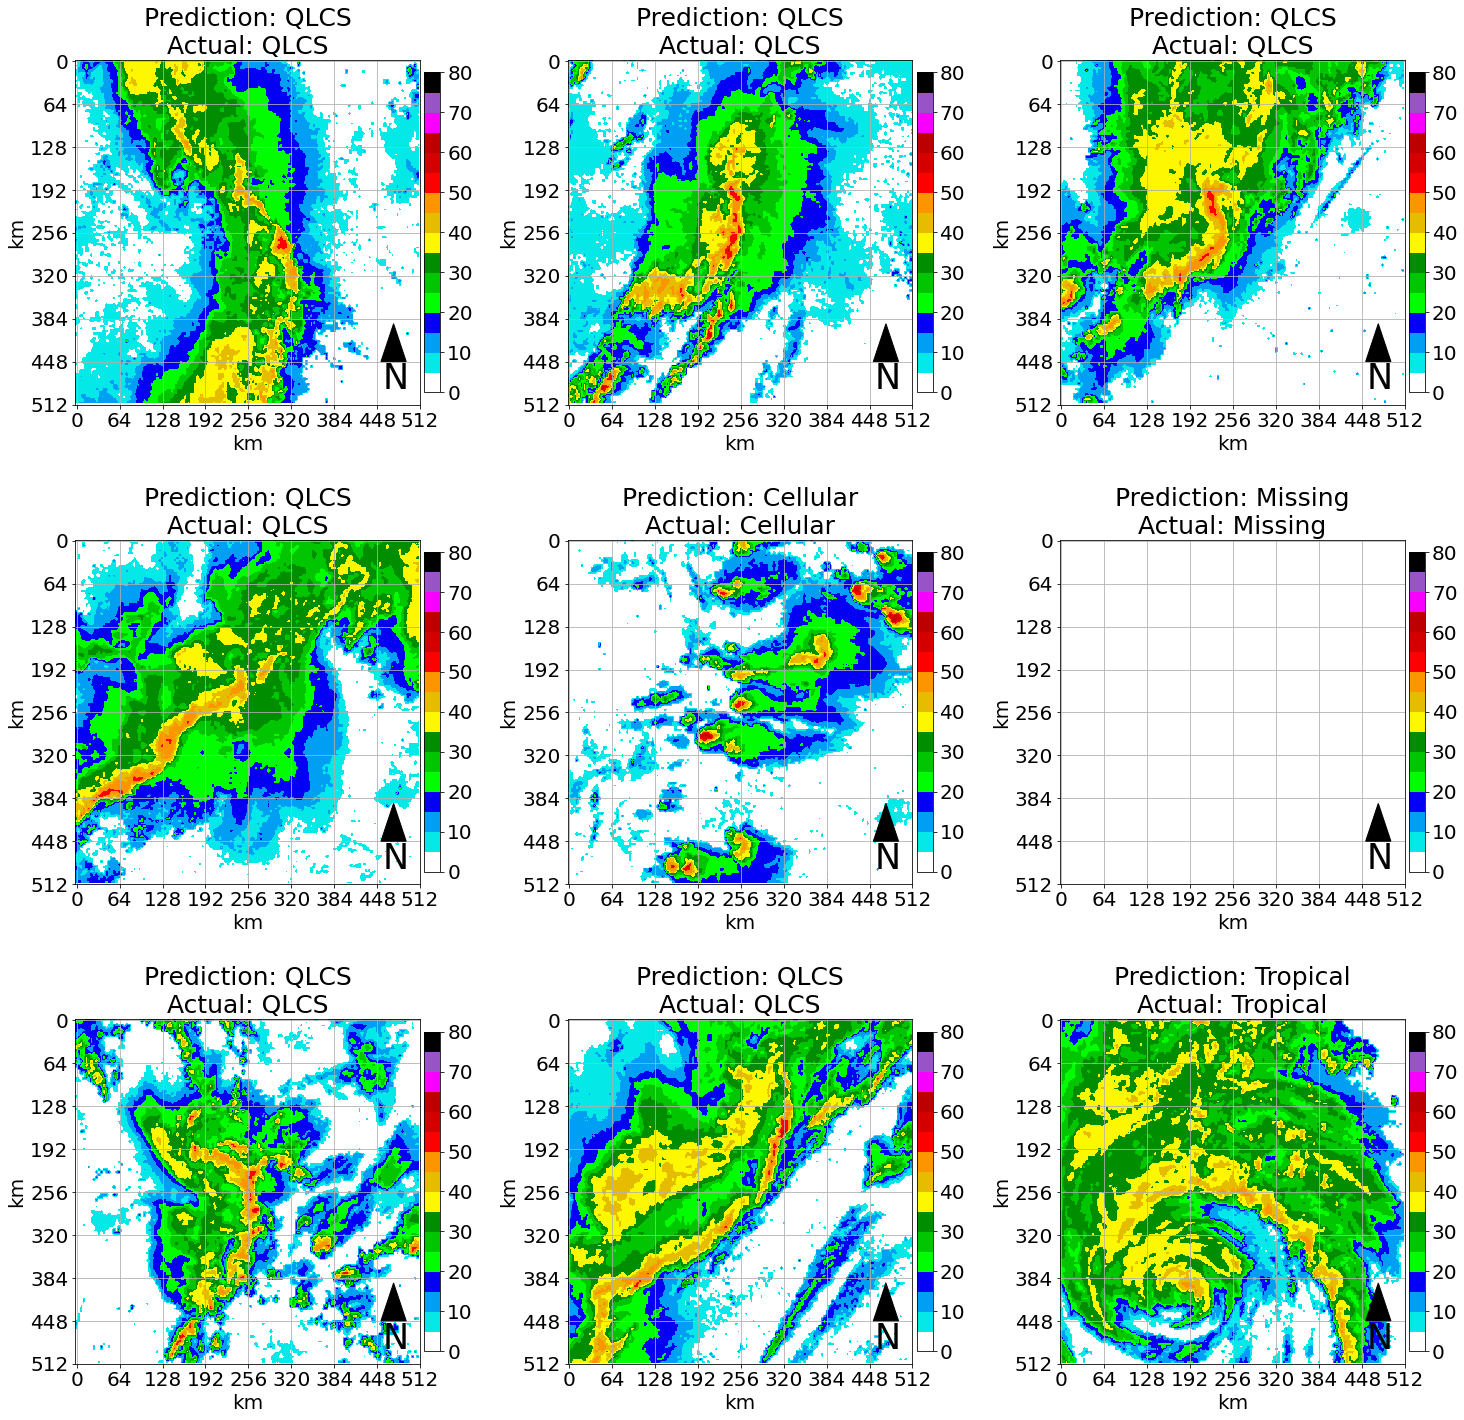

In [12]:
from utils.get_images import get_img_list

plt.rcParams['figure.figsize'] = 25, 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

#Testing data are 2014 and on.  It is "cheating" to look at earlier data.
sample = actual[actual.yr>=2014].sample(9)

#Load the images and transform them to be "CNN-friendly"
imgs = get_img_list(sample.index.values, "../data/tor/")
imgs = expand_dims(imgs, 3)
imgs = imgs / 80 #normalize

#Identify the column with the highest probability
pred = np.argmax(model.predict(imgs), axis=1)
truth = sample['Class Code'].values

lookup = {0:'Cellular', 1:'QLCS', 2:'Tropical', 3:'Other', 4:'Noise', 5:'Missing'}

for i, (img, p) in enumerate(zip(imgs, pred)):
    
    ax = plt.subplot(3, 3, i+1)
    
    ax = draw_box_plot(ax, img*80, cbar_shrink=0.8)
    
    ax.set_title("Prediction: {}\nActual: {}".format(lookup[p], lookup[truth[i]]), fontsize=25)